In [1]:
import os
# Prevent TensorFlow from hogging all GPU memory so JAX can use it too
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from keras_tft import TFTForecaster, plot_probabilistic_forecast, preprocess_timeseries, timeseries_cv, plot_feature_importance

2025-12-06 00:15:28.996069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764972929.010248    5317 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764972929.014935    5317 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764972929.026301    5317 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764972929.026314    5317 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764972929.026316    5317 computation_placer.cc:177] computation placer alr

The dataset tracks the weekly sales of many Walmart stores from February 5, 2010 to October 26, 2012 as the forecasting scenario. This dataset is released under the Creative Commons 0 license. Although the original dataset tracked thousands of stores, we’ll use a subset of only four stores.

In [2]:
FORECAST_HORIZON = 2
INPUT_LEN = 16  # 4 months of history 
EPOCHS = 15 # Number of epochs for training

# Walmart sales dataset
path = 'data/walmart_sales_small.csv'

In [3]:
CUTOFF_DATE = '2012-08-01'
# Preprocess data
# The function now returns history and the full prediction input (history + future)
data, pred_input, test_df, scaler = preprocess_timeseries(
    cutoff_date=CUTOFF_DATE,
    target_col='Weekly_Sales',
    file_path=path,
    forecast_horizon=FORECAST_HORIZON,
    static_covariates=['Store'],     
)

data.head()

,id_column,timestamp,y,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Flag
0,1,2010-02-05,0.390823,-1.594146,-1.433373,0.436887,0.903796,0
143,2,2010-02-05,0.538659,-1.732826,-1.433373,0.427909,1.125108,0
286,3,2010-02-05,0.036570,-1.371735,-1.433373,0.523818,0.154583,0
429,4,2010-02-05,0.538106,-1.499294,-1.372115,-1.774048,1.428651,0
144,2,2010-02-12,0.538905,-1.844032,-1.489919,0.431706,1.125108,1


In [4]:
pred_input.tail()

,id_column,timestamp,y,Temperature,Fuel_Price,CPI,Unemployment,Holiday_Flag
517,2,2012-07-27,0.425057,1.288041,0.533944,0.710652,-0.660618,0
518,3,2012-07-27,0.014934,1.194498,0.533944,0.811862,-0.895128,0
519,1,2012-07-27,0.329516,1.045352,0.533944,0.720126,-0.312406,0
520,1,2012-08-03,0.000000,1.271034,0.557505,0.720350,-0.312406,0
521,2,2012-08-03,0.000000,1.539889,0.557505,0.710873,-0.660618,0


In [5]:
# Initialize TFT Forecaster model
model = TFTForecaster(
    input_chunk_length=INPUT_LEN,
    output_chunk_length=FORECAST_HORIZON,
    quantiles=[0.1, 0.5, 0.9]
)

In [6]:
# Train the model
model.fit(
    data,
    target_col="y",
    exogenous=["Temperature", "Fuel_Price", "CPI",
                     "Unemployment", "Holiday_Flag"],
    static_cov_cols=['id_column'],
    epochs=EPOCHS,
    use_early_stopping=True, early_stopping_patience=2
)

2025-12-06 00:15:34.464545: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1764972934.465779    5317 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 889 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Training with tf.data pipeline...
Past features: 6 | Future features: 5 | Static features: 1
Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - loss: 0.3502 - learning_rate: 0.0010
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1423 - learning_rate: 0.0010
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1198 - learning_rate: 0.0010
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1079 - learning_rate: 0.0010
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0973 - learning_rate: 0.0010
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0897 - learning_rate: 0.0010
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0851 - learning_rate: 0.0010
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0820 - learning_rate: 0.0010
Epoch 9/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0780 - learning_rate: 0.0010
Epoch 10/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0829 - learning_rate: 0.0010
Epoch 

In [7]:
# Forecast
forecast = model.predict(pred_input)
forecast

,q10,q50,q90,id_column
timestamp,,,,
2012-07-27,0.266176,0.325486,0.403423,1
2012-08-03,0.266906,0.325945,0.402735,1
2012-07-27,0.380342,0.440721,0.539201,2
2012-08-03,0.380087,0.440158,0.538176,2
2012-07-20,-0.043558,0.042610,0.062654,3
2012-07-27,-0.043190,0.042107,0.062188,3
2012-07-20,0.435121,0.508459,0.622291,4
2012-07-27,0.435884,0.507421,0.615987,4


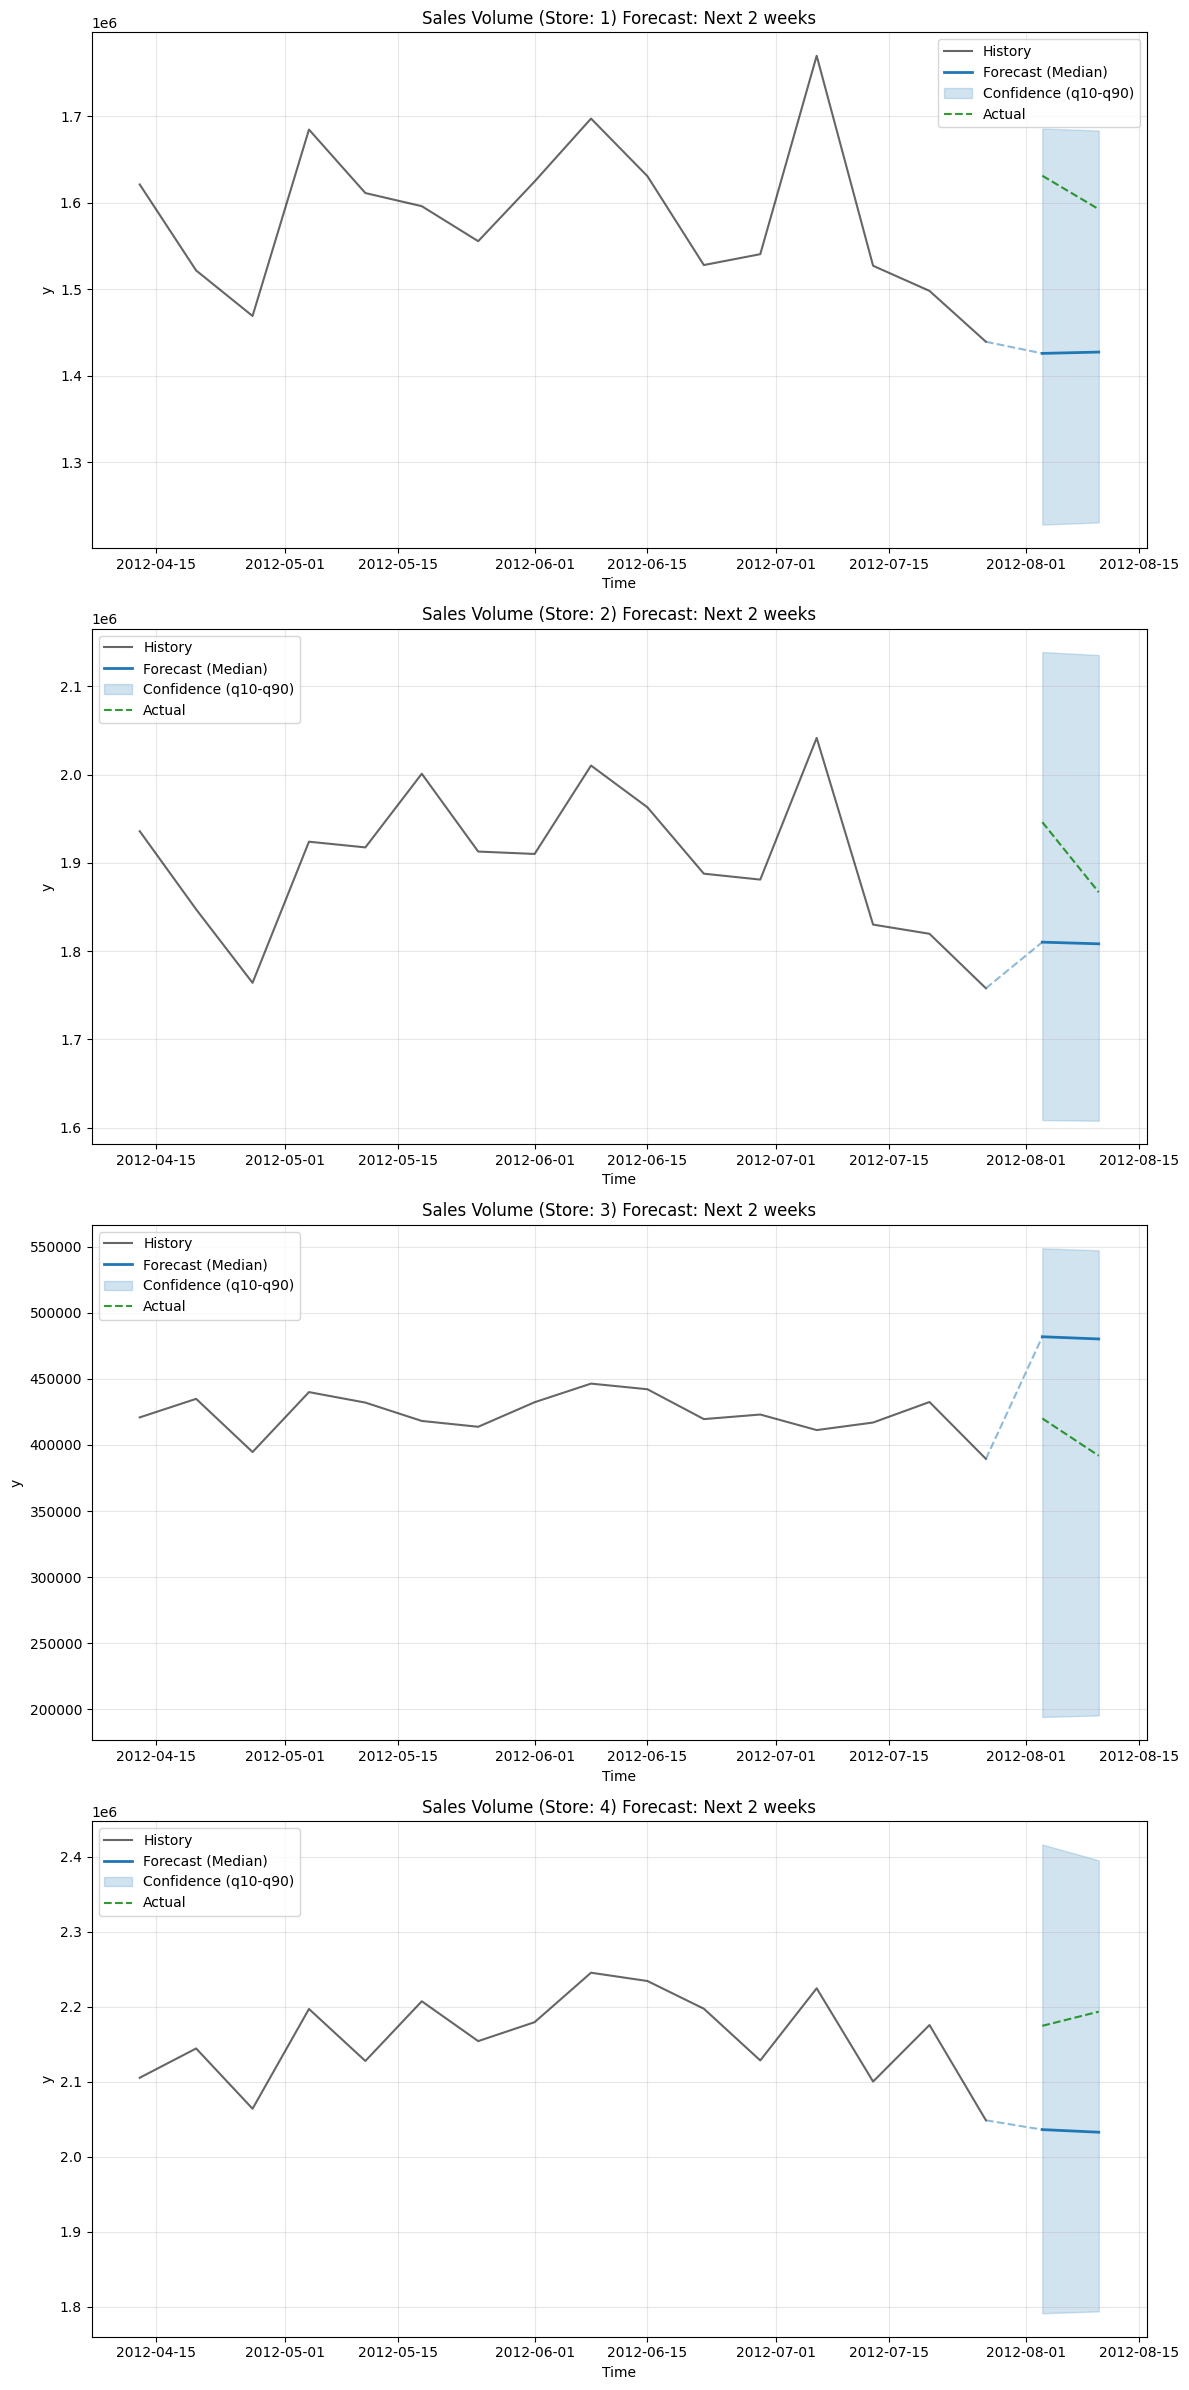

In [8]:
# Plot the probabilistic forecast
plot_probabilistic_forecast(
    history_df=data,
    id_col_name="Store",
    forecast_df=forecast,
    target_col="y",
    scaler=scaler,
    actual_df=test_df,
    timeseries_name="Sales Volume",
    time_col="timestamp",
    history_length=INPUT_LEN
)

In [9]:
results = timeseries_cv(
    model=model, # Pass the instantiated TFTForecaster model object
    df=data,
    num_windows=5,
    future_cov_cols=["Temperature", "Fuel_Price", "CPI",
                     "Unemployment", "Holiday_Flag"],
    forecast_horizon=FORECAST_HORIZON
)


CROSS-VALIDATION: 2012-06-01 to 2012-07-27 (Test Ends)
Forecast Horizon: 2 weeks | Windows: 5

Window   1 | Date: 2012-05-25 | Train:  480 weeks | RMSE:   0.25 | MAE:   0.20 | MAPE: 373.81%
Window   2 | Date: 2012-06-08 | Train:  488 weeks | RMSE:   0.42 | MAE:   0.37 | MAPE: 99.29%
Window   3 | Date: 2012-06-22 | Train:  496 weeks | RMSE:   0.33 | MAE:   0.26 | MAPE: 302.25%
Window   4 | Date: 2012-07-06 | Train:  504 weeks | RMSE:   0.29 | MAE:   0.24 | MAPE: 383.64%
Window   5 | Date: 2012-07-20 | Train:  512 weeks | RMSE:   0.31 | MAE:   0.24 | MAPE: 419.30%

CROSS-VALIDATION SUMMARY
Total Windows: 5
Overall RMSE: 0.32
Overall MAE:  0.26
Overall MAPE: 315.66%



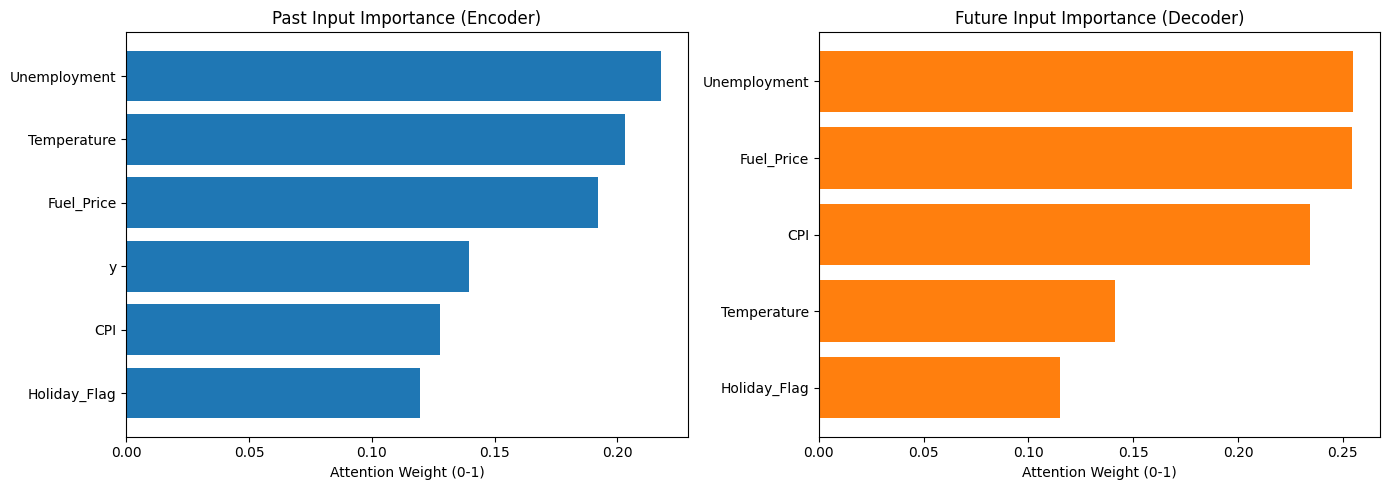

In [10]:
# Feature Importance Analysis

# Extract feature importance
importance_results = model.get_feature_importance(data)

# Plot importance (handles printing and plotting internally)
plot_feature_importance(importance_results)